In [1]:
import json
import os
import ml_collections
import torch
from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.data_pipeline import pretrain_dataloaders as dataloaders
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict


config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/pretrain/pretrain_config_layernorm_std_small_batch_6_datasets.json'
with open(config_path, "r", encoding="utf-8") as f:
  config = json.load(f)
config = ml_collections.ConfigDict(config)
config.data_config.local_batch_size = 128

#### Override config
# config.data_config.amp_norm_type = 'std'
# config.data_config.demean = False
# config.data_config.amp_norm = False

In [3]:
seed_everything(config.seed)
model = LitMultiDimWav2Vec2(config)

DEFAULT_NUM_WORKERS = 4

data_collator = \
  collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
      config=config.model_config,
      mask_time_prob=config.training_config.mask_time_prob,
      mask_time_length=config.training_config.mask_time_length,
)

config.data_config.num_workers = int(
    os.environ.get('SLURM_CPUS_PER_TASK', DEFAULT_NUM_WORKERS)
)


Seed set to 42


In [28]:
all_data_name = [
      # "ETHZ",
      # "GEOFON",
      # "STEAD",
      # "NEIC",
      "InstanceCounts",
      # "Iquique"
    ][::-1]


train_loaders = {}
dev_loaders = {}

for data_name in all_data_name:

  print(f'Processing {data_name}')
  train_loader, dev_loader = dataloaders.prepare_pretrain_dataloaders(
    model=model,
    training_fraction=config.data_config.training_fraction,
    data_names=[data_name],
    missing_components='copy',
    batch_size=config.data_config.local_batch_size,
    num_workers=config.data_config.num_workers,
    prefetch_factor=config.data_config.prefetch_factor,
    collator=data_collator,
    cache=config.data_config.cache_dataset,
  )
  train_loaders[data_name] = train_loader
  dev_loaders[data_name] = dev_loader

Processing InstanceCounts


Seed set to 42
Seed set to 42


In [34]:
import numpy as np
batch = next(iter(train_loaders['InstanceCounts']))


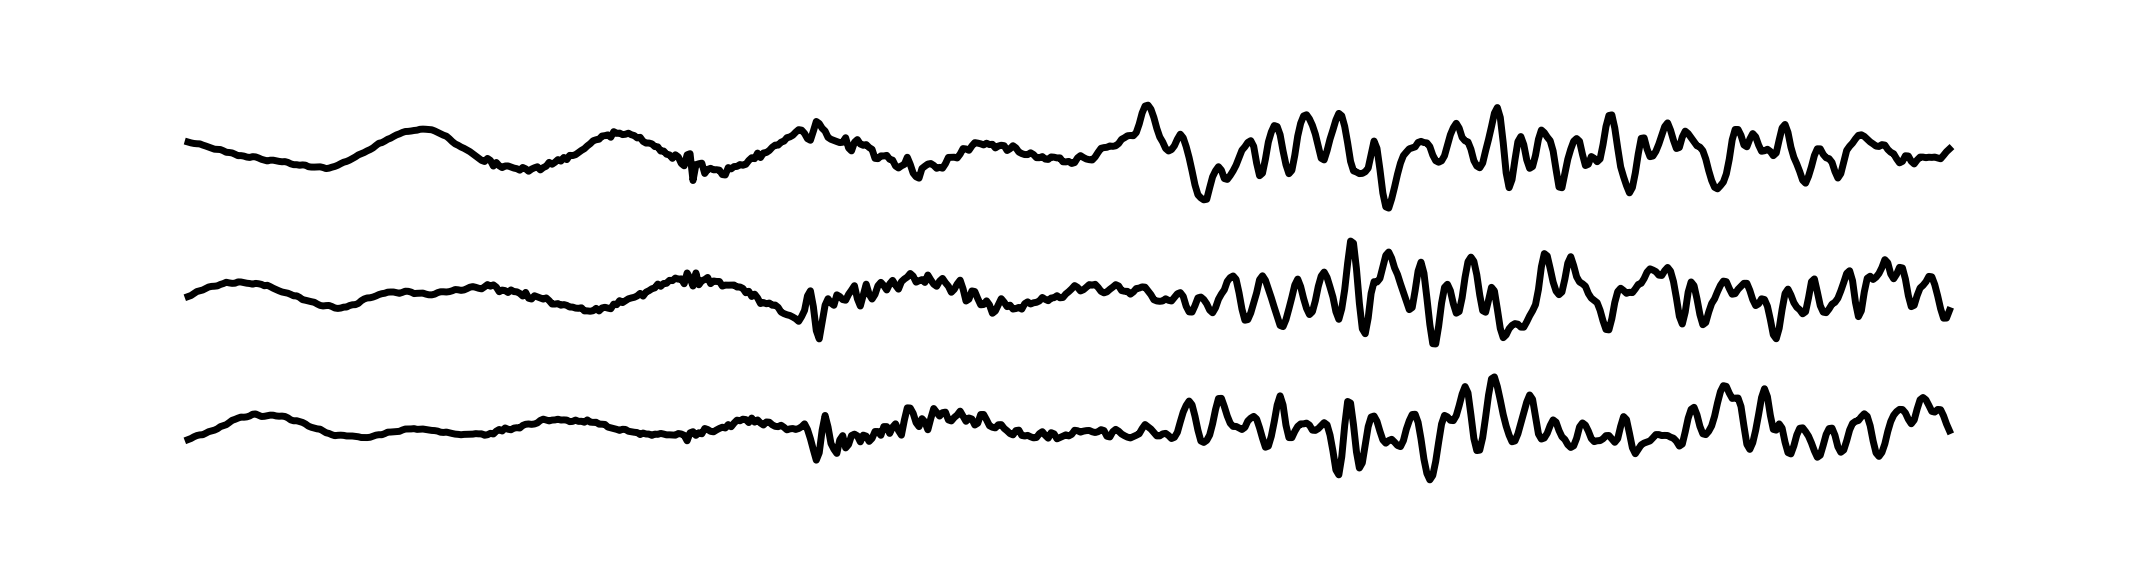

In [46]:
input_values = batch['input_values'][0]

fig, axs = plt.subplots(3, 1, figsize=(2.5, 0.5), dpi=1000)

# Plotting each channel in a separate subplot
channels = [input_values[0], input_values[1], input_values[2]]
for i, ax in enumerate(axs):
    ax.plot(channels[i][::5], color='black', lw=0.5)
    ax.axis('off')  # Remove axes
    ax.set_facecolor('none')  # Transparent background for each subplot

# Set the figure background to transparent
fig.patch.set_alpha(0)

# Saving the figure with a transparent background
plt.savefig(
  '/scicore/home/dokman0000/liu0003/projects/seisLM/results/figures/demo_channels_plot.pdf',
  transparent=True, bbox_inches='tight', dpi=1000)



In [6]:

THRESHOLD = 100

# Define the nested defaultdict
abnormality_dict = defaultdict(list)

for dataset_name in all_data_name:
  batch_idx = 0
  for batch in tqdm.tqdm(train_loaders[dataset_name]):

    input_values = batch['input_values']
    std_norm_input_values = input_values
    # # Normalize input values
    # peak_norm_input_values = input_values / torch.max(
    #     torch.abs(input_values), dim=-1, keepdim=True).values
    # std_norm_input_values = input_values / (
    #     torch.std(input_values, dim=-1, keepdim=True) + 1e-10)

    std_norm_input_values_max = std_norm_input_values.abs().max().item()

    if std_norm_input_values_max > THRESHOLD:
      for idx in range(std_norm_input_values.shape[0]):
        trace = std_norm_input_values[idx]
        if trace.abs().max().item() > THRESHOLD:

          print(f'abnormal max_input_values: {trace.abs().max().item()} > {THRESHOLD} | {dataset_name} | batch idx {batch_idx} | trace idx {idx}')
          abnormality_dict[dataset_name].append(input_values[idx])
          break

    batch_idx += 1

100%|██████████| 7628/7628 [12:41<00:00, 10.02it/s]


In [6]:
dataset_name = 'NEIC'
threshold = 100
iter_dataloader = iter(train_loaders[dataset_name])

abnormal max_input_values: 5000000000.0 > 100; break 

abnormal max_input_values: 5000000000.0 > 100; break 



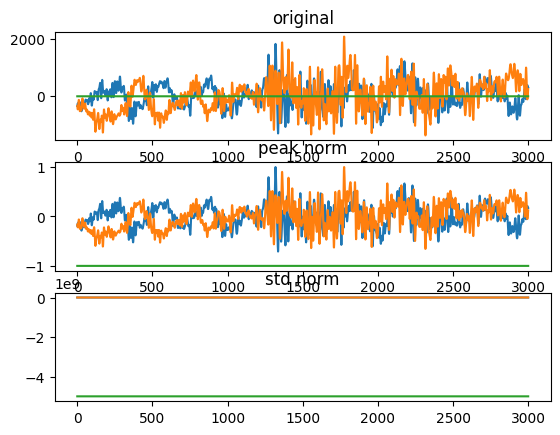

In [26]:


# for batch in tqdm.tqdm(train_loaders[dataset_name]):
batch = next(iter_dataloader)
input_values = batch['input_values']
peak_norm_input_values = input_values / torch.max(
  torch.abs(input_values), axis = -1, keepdim=True).values
std_norm_input_values = input_values / (
  torch.std(input_values, axis = -1, keepdim=True) + 1e-10)

std_norm_input_values_max = std_norm_input_values.abs().max().item()

if std_norm_input_values_max > threshold:
  print(f'abnormal max_input_values: {std_norm_input_values_max} > 100; break \n')
  # break

# identify the exact trace that causes the abnormal max_input_values
for id in range(std_norm_input_values.shape[0]):
  trace = std_norm_input_values[id]
  if trace.abs().max().item() > threshold:
    print(f'abnormal max_input_values: {trace.abs().max().item()} > 100; break \n')
    # break

    fig, axes = plt.subplots(3, 1)
    axes[0].plot(input_values[id].T)
    axes[0].set_title('original')

    axes[1].plot(peak_norm_input_values[id].T)
    axes[1].set_title('peak norm')

    axes[2].plot(std_norm_input_values[id].T)
    axes[2].set_title('std norm')
    break

In [30]:
(torch.max(
  torch.abs(input_values), axis = -1, keepdim=True).values)[id]

tensor([[1.8302e+03],
        [2.0844e+03],
        [5.0000e-01]])

In [29]:
input_values[id]

tensor([[-341.4863, -308.1973, -277.5723,  ...,  305.6172,  294.9277,
          304.3945],
        [-345.2136, -387.3114, -428.5804,  ...,   60.0897,  154.3301,
          253.0353],
        [  -0.5000,   -0.5000,   -0.5000,  ...,   -0.5000,   -0.5000,
           -0.5000]])

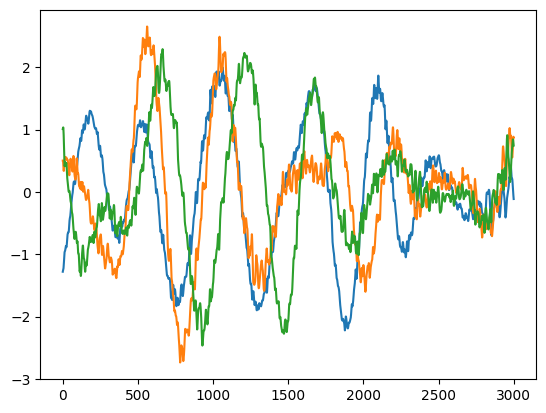

In [10]:
atch = next(iter_dataloader)
input_values = batch['input_values']

plt.plot(input_values[10].T)

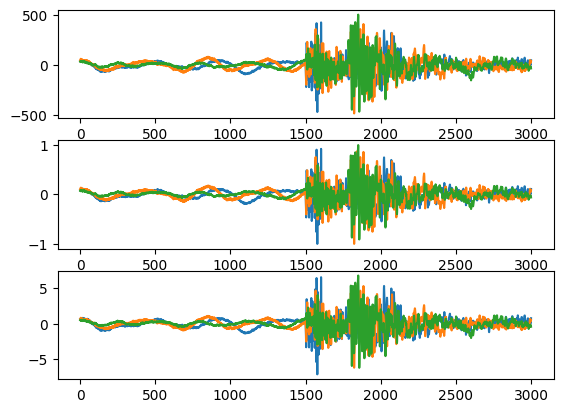

In [34]:
iter_loader = iter(train_loaders['ETHZ'])
batch = next(iter_loader)


input_values = batch['input_values']
peak_norm_input_values = input_values / torch.max(torch.abs(input_values), axis = -1, keepdim=True).values
std_norm_input_values = input_values / torch.std(input_values, axis = -1, keepdim=True)

fig, axes = plt.subplots(3, 1)
axes[0].plot(input_values[0].T)
axes[1].plot(peak_norm_input_values[0].T)
axes[2].plot(std_norm_input_values[0].T)

 66%|██████▌   | 41/62 [00:04<00:02,  9.90it/s]

abnormal max_input_values: 915527.3125 > 100; break 



 71%|███████   | 44/62 [00:05<00:02,  8.03it/s]


abnormal max_input_values: 915527.3125 > 100; break 



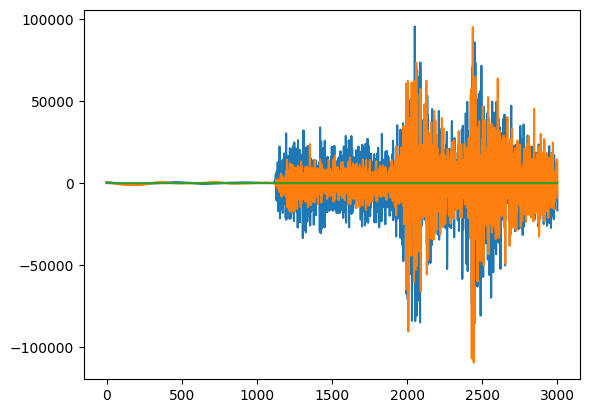

In [59]:
plt.plot(input_values[id].T)

In [63]:
input_values[id][-1]

tensor([-9.1553e-05, -9.1553e-05, -9.1553e-05,  ..., -9.1553e-05,
        -9.1553e-05, -9.1553e-05])

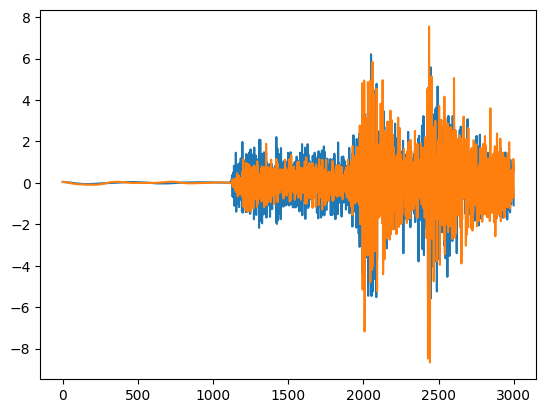

In [65]:
plt.plot(std_norm_input_values[id][:-1].T)

In [57]:
trace[0]

tensor([ 0.0432,  0.0418,  0.0412,  ..., -0.3450, -0.5734, -1.0804])

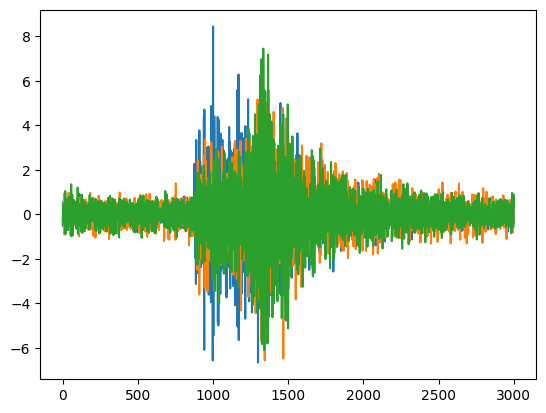

In [6]:
plt.plot( (input_values[idx] / input_values[idx].std()).T)

In [7]:
batch['input_values'].abs().max()

tensor(26.7097)

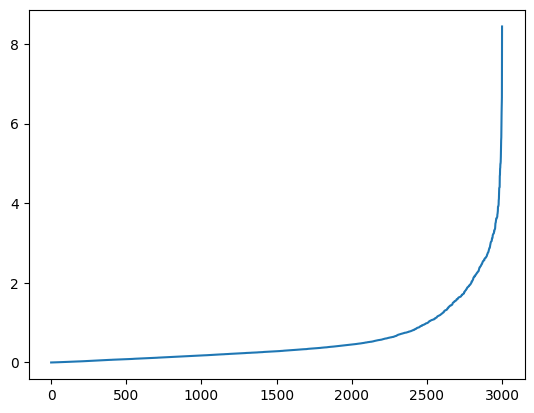

In [8]:
plt.plot(
  batch['input_values'][idx][0].abs().sort().values
)

In [9]:
input_values[idx]

tensor([[-0.4459, -0.5001, -0.1178,  ..., -0.4447, -0.1230,  0.3742],
        [ 0.4502,  0.3516,  0.1287,  ...,  0.3854,  0.0774, -0.2390],
        [-0.3462,  0.2704,  0.4458,  ..., -0.1405,  0.8924,  0.3545]])

In [10]:
len(train_loader)

176